In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("default")


In [6]:
df = pd.read_csv("../data/cleaned_aqi_data.csv")
df.head()


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI,quality
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462,Severe
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482,Severe
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263,Poor
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207,Poor
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149,Moderate


In [7]:
X = df.drop(columns=["AQI", "quality", "date"], errors="ignore")
y = df["AQI"]



In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)



In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    )
}


In [17]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,27.709515,2642.726224,51.407453,0.747262
1,Decision Tree,33.416382,2590.412969,50.896100,0.752265
2,Gradient Boosting,21.068818,985.273291,31.389063,0.905773
3,Random Forest,20.685290,992.261472,31.500182,0.905105


In [12]:
# Compare shuffled vs time-aware split
X_tr_s, X_te_s, y_tr_s, y_te_s = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_tr_s, y_tr_s)
print("Shuffled R2:", r2_score(y_te_s, rf.predict(X_te_s)))

rf.fit(X_train, y_train)
print("Time-aware R2:", r2_score(y_test, rf.predict(X_test)))


Shuffled R2: 0.9353005029059869
Time-aware R2: 0.9051047923038109


In [18]:
rf = models["Random Forest"]
preds = rf.predict(X_test)

print("AQI actual range:", y_test.min(), y_test.max())
print("AQI predicted range:", preds.min(), preds.max())


AQI actual range: 45 468
AQI predicted range: 36.09 441.115


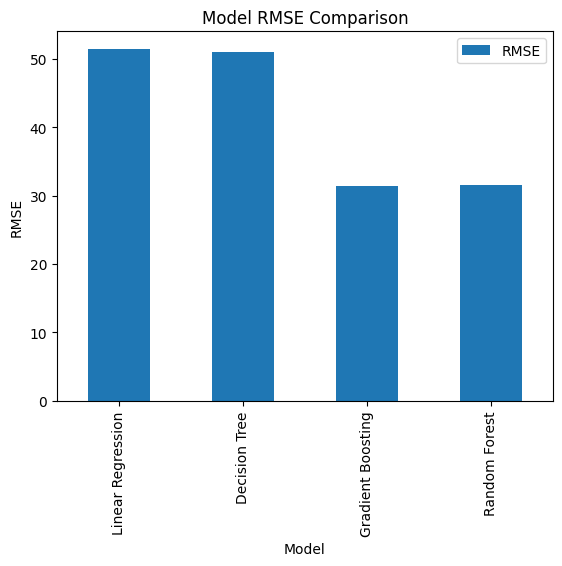

In [19]:
results_df.set_index("Model")[["RMSE"]].plot(kind="bar")
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()


In [20]:
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5, scoring="r2"
    )
    cv_scores[name] = scores


C:\Users\hp\AppData\Local\Temp\ipykernel_1688\2658432382.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_scores.values(), labels=cv_scores.keys())


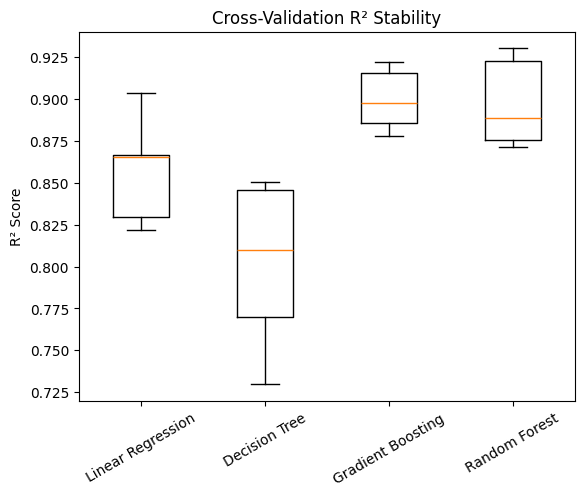

In [21]:
plt.boxplot(cv_scores.values(), labels=cv_scores.keys())
plt.title("Cross-Validation R² Stability")
plt.ylabel("R² Score")
plt.xticks(rotation=30)
plt.show()


***Time-Series Error Drift***

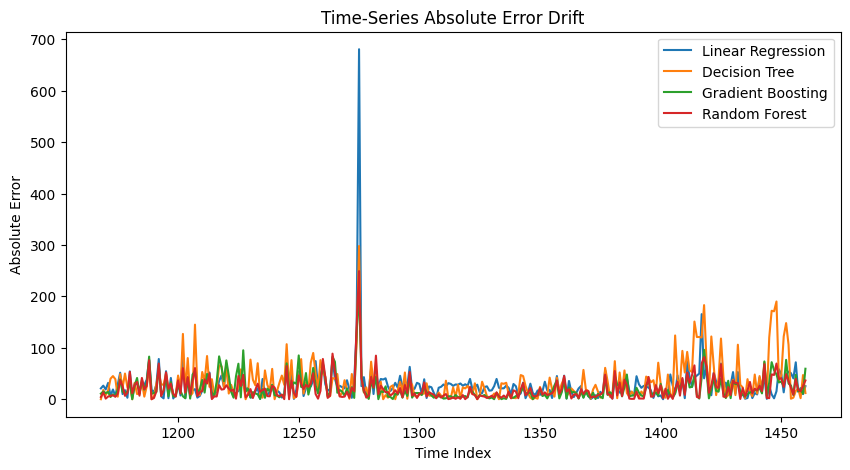

In [22]:
plt.figure(figsize=(10,5))

for name, model in models.items():
    preds = model.predict(X_test)
    error = np.abs(y_test - preds)
    plt.plot(error, label=name)

plt.title("Time-Series Absolute Error Drift")
plt.xlabel("Time Index")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()
